In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

In [2]:
with ZipFile("archive.zip","r") as zip:
    zip.extractall()

In [3]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

batch_size = 32
img_size = (224,224)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = img_size,
    batch_size  = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


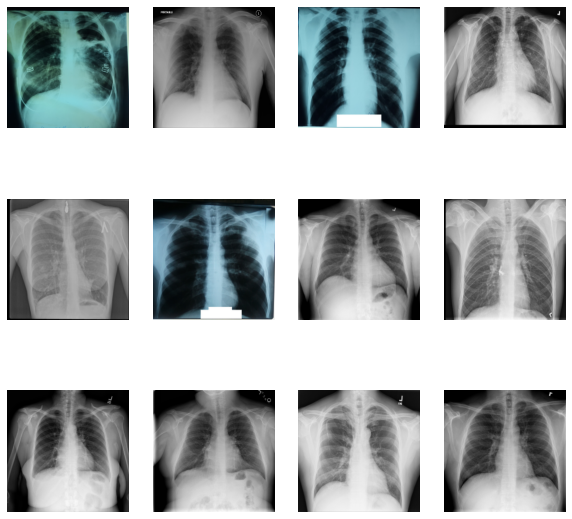

In [5]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
	RandomZoom(0.2),
])

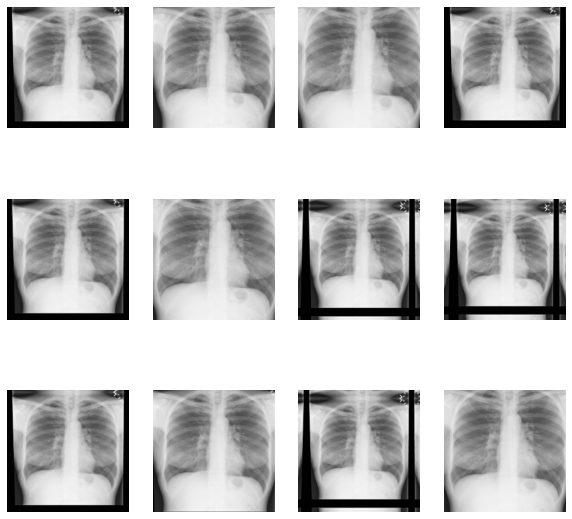

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Build the model

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

input_shape = img_size+(3,)

class Tuber():
    def model(self,y):
        self.x = data_augmentation(y)
        self.x = Rescaling(1./255)(self.x)
        self.x = Conv2D(64,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = MaxPooling2D()(self.x)
        self.x = Conv2D(128,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = Conv2D(128,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = Conv2D(256,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = MaxPooling2D()(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(64,activation="relu")(self.x)
        self.x = Dropout(0.4,seed=123)(self.x)
        self.x = Dense(32,activation="relu")(self.x)
        self.x = Dropout(0.4,seed=123)(self.x)
        self.outputs = Dense(2,activation="sigmoid")(self.x)
        self.model = tf.keras.Model(y,self.outputs)
        return self.model

tuber = Tuber()
model = tuber.model(tf.keras.Input(shape=input_shape))
model.summary()
model.compile(tf.keras.optimizers.Adam(),tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584

### Train and test the model

In [10]:
if __name__=="__main__":
    initial_epochs = 50
    loss0,accuracy0 = model.evaluate(val_ds)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=initial_epochs,validation_data=val_ds,callbacks=[checkpoint])
    best = tf.keras.models.load_model("tuberculosis.hdf5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nTest accuracy: {:.2f} %".format(100*accuracy))
    print("Test loss: {:.2f} %".format(100*loss))

22/22 [==============================] - 3s 29ms/step - loss: 0.7178 - accuracy: 0.1721
Epoch 1/50
105/105 [==============================] - 6s 52ms/step - loss: 0.3957 - accuracy: 0.8500 - val_loss: 0.2128 - val_accuracy: 0.8985
Epoch 2/50
105/105 [==============================] - 6s 52ms/step - loss: 0.2255 - accuracy: 0.9122 - val_loss: 0.1995 - val_accuracy: 0.8971
Epoch 3/50
105/105 [==============================] - 6s 52ms/step - loss: 0.3266 - accuracy: 0.8583 - val_loss: 0.2296 - val_accuracy: 0.8912
Epoch 4/50
105/105 [==============================] - 6s 55ms/step - loss: 0.2529 - accuracy: 0.8896 - val_loss: 0.2402 - val_accuracy: 0.8985
Epoch 5/50
105/105 [==============================] - 6s 55ms/step - loss: 0.2419 - accuracy: 0.8994 - val_loss: 0.2863 - val_accuracy: 0.8794
Epoch 6/50
105/105 [==============================] - 6s 55ms/step - loss: 0.2523 - accuracy: 0.8955 - val_loss: 0.2394 - val_accuracy: 0.8853
Epoch 7/50
105/105 [==============================] - 